In [2]:
import datetime
import os
from tensorboardX import SummaryWriter

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
  root='./dataset/', train=True, transform=transform, download=True
)

test_dataset = datasets.MNIST(
  root='./dataset/', train=False, transform=transform, download=True
)

train_loader = DataLoader(
  train_dataset, batch_size=100, shuffle=True, num_workers=4
)

test_loader = DataLoader(
  test_dataset, batch_size=100, shuffle=False, num_workers=4
)

# Define VAE

In [6]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Encoder, self).__init__()
    self.input1 = nn.Linear(input_dim, hidden_dim)
    self.input2 = nn.Linear(hidden_dim, hidden_dim)
    self.mean = nn.Linear(hidden_dim, latent_dim)
    self.var = nn.Linear(hidden_dim, latent_dim)
    
    self.LeakyReLU = nn.LeakyReLU(0.2)
    self.training = True
    
  def forward(self, x):
    h_ = self.LeakyReLU(self.input1(x))
    h_ = self.LeakyReLU(self.input2(h_))
    mean = self.mean(h_)
    log_var = self.var(h_)
    return mean, log_var

In [7]:
class Decoder(nn.Module):
  def __init__(self, latent_dim, hidden_dim, output_dim):
    super(Decoder, self).__init__()
    self.hidden1 = nn.Linear(latent_dim, hidden_dim)
    self.hidden2 = nn.Linear(hidden_dim, hidden_dim)
    self.output = nn.Linear(hidden_dim, output_dim)
    self.LeakyReLU = nn.LeakyReLU(0.2)
    
  def forward(self, x):
    h = self.LeakyReLU(self.hidden1(x))
    h = self.LeakyReLU(self.hidden2(h))
    x_hat = torch.sigmoid(self.output(h))
    return x_hat

In [37]:
class Model(nn.Module):
  def __init__(self, Encoder, Decoder):
    super(Model, self).__init__()
    self.Encoder = Encoder
    self.Decoder = Decoder
   
  # 평균과 표준 편차가 주어졌을 때, latent vector z를 만들기 위한(=sampling하기 위한) 함수
  #  z는 gaussian 분포로 가정했기 때문에, encoder에서 받아 온 평균과 표준 편차를 이용해 z를 생성한다.
  def reparameterization(self, mean, var):
    epsilon = torch.rand_like(var).to(device)
    z = mean + var * epsilon
    return z
  
  def forward(self, x):
    mean, log_var = self.Encoder(x)
    z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # 표준 편차 값이 음수가 되지 않도록 로그를 취하는 방식 사용함.
    x_hat = self.Decoder(z)# z 벡터를 decoder에 통과시켜서, 입력과 동일한 데이터(x')을 만들어 내는 작업.
    return x_hat, mean, log_var

### Encoder, Decoder 객체 초기화

In [38]:
x_dim = 784
hidden_dim = 400
latent_dim = 200
epochs = 30
batch_size = 100

In [39]:
encoder = Encoder(
  input_dim=x_dim,
  hidden_dim=hidden_dim,
  latent_dim=latent_dim
)

decoder = Decoder(
  latent_dim=latent_dim,
  hidden_dim=hidden_dim,
  output_dim=x_dim
)

model = Model(Encoder=encoder, Decoder=decoder).to(device)
model = nn.DataParallel(model)

# Define Loss function and optimizer

In [40]:
def loss_function(x, x_hat, mean, log_var):
  reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
  KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
  return reproduction_loss, KLD

In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [42]:
saved_loc = './tensorboard_scalar'
writer = SummaryWriter(saved_loc)

# Train VAE

In [43]:
model.train()

def train(epoch, model, train_loader, optimizer):
  train_loss = 0
  for batch_idx, (x, _) in enumerate(train_loader):
    
    x = x.view(batch_size, x_dim)
    x = x.to(device)

    optimizer.zero_grad()
    x_hat, mean, log_var = model(x)
    BCE, KLD = loss_function(x, x_hat, mean, log_var)
    loss = BCE + KLD
    
    writer.add_scalar("Train/Reconstruction Error", BCE.item(), 
                      batch_idx + epoch * (len(train_loader.dataset)/batch_size))
    writer.add_scalar("Train/KL-Divergence", KLD.item(), 
                      batch_idx + epoch * (len(train_loader.dataset)/batch_size))
    writer.add_scalar("Train/Total Loss", loss.item(), 
                      batch_idx + epoch * (len(train_loader.dataset)/batch_size))
    
    train_loss += loss.item()
    loss.backward()
    optimizer.step()
    
    if batch_idx % 100 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'
            .format(epoch, batch_idx*len(x), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item() / len(x)))
      
      print("======> Epoch: {} Average Loss: {:.4f}"
            .format(epoch, train_loss / len(train_loader.dataset)))
    
    

In [48]:
def test(epoch, model, test_loader):
  model.eval()
  test_loss = 0
  with torch.no_grad():
    for batch_idx, (x,_) in enumerate(test_loader):
      x = x.view(batch_size, x_dim)
      x = x.to(device)
      x_hat, mean, log_var = model(x)
      BCE, KLD = loss_function(x, x_hat, mean, log_var)
      loss = BCE + KLD
      
      writer.add_scalar("Test/Reconstruction Error", BCE.item(), 
                      batch_idx + epoch * (len(test_loader.dataset)/batch_size))
      writer.add_scalar("Test/KL-Divergence", KLD.item(), 
                      batch_idx + epoch * (len(test_loader.dataset)/batch_size))
      writer.add_scalar("Test/Total Loss", loss.item(), 
                      batch_idx + epoch * (len(test_loader.dataset)/batch_size))
      
      test_loss += loss.item()
      
      if batch_idx == 0:
        n = min(x.size(0), 8)
        comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
        grid = torchvision.utils.make_grid(comparison.cpu())
        writer.add_image("Test image - Above: Real data, below: reconstruction data", grid, epoch)
      

In [47]:
from tqdm.auto import tqdm
for epoch in tqdm(range(0, epochs)):
  train(epoch, model, train_loader, optimizer)
  test(epoch, model, test_loader)
  print("\n")
writer.close()

  0%|          | 0/30 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	 Loss: 117.073232
======> Epoch: 0 Average Loss: 0.1951
Train Epoch: 0 [10000/60000 (17%)]	 Loss: 112.569063
======> Epoch: 0 Average Loss: 19.7669
Train Epoch: 0 [20000/60000 (33%)]	 Loss: 114.339033
======> Epoch: 0 Average Loss: 38.6350
Train Epoch: 0 [30000/60000 (50%)]	 Loss: 106.455137
======> Epoch: 0 Average Loss: 56.9201
Train Epoch: 0 [40000/60000 (67%)]	 Loss: 109.703232
======> Epoch: 0 Average Loss: 74.7653
Train Epoch: 0 [50000/60000 (83%)]	 Loss: 103.145625
======> Epoch: 0 Average Loss: 92.2125


Train Epoch: 1 [0/60000 (0%)]	 Loss: 99.267432
======> Epoch: 1 Average Loss: 0.1654
Train Epoch: 1 [10000/60000 (17%)]	 Loss: 95.069121
======> Epoch: 1 Average Loss: 16.9675
Train Epoch: 1 [20000/60000 (33%)]	 Loss: 96.321191
======> Epoch: 1 Average Loss: 33.5499
Train Epoch: 1 [30000/60000 (50%)]	 Loss: 100.209502
======> Epoch: 1 Average Loss: 50.0538
Train Epoch: 1 [40000/60000 (67%)]	 Loss: 100.019736
======> Epoch: 1 Average Loss: 66.3872
T

# Generate images from test dataset

In [51]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        
        x_hat, _, _ = model(x)

        break

  0%|          | 0/100 [00:00<?, ?it/s]

In [52]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

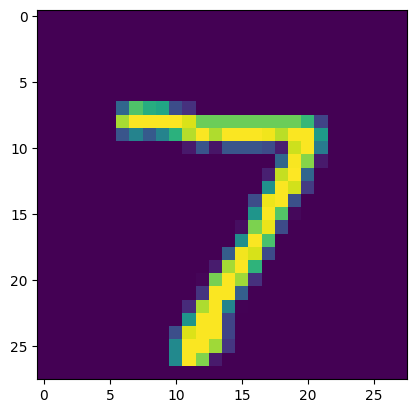

In [53]:
show_image(x, idx=0)

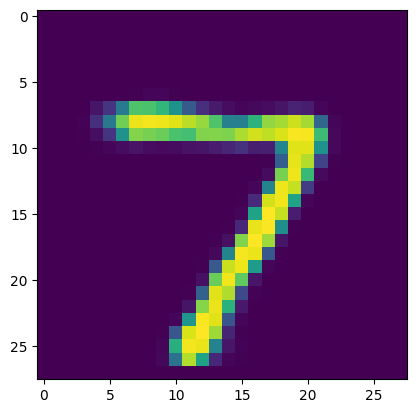

In [54]:
show_image(x_hat, idx=0)

In [50]:
%load_ext tensorboard
%tensorboard --logdir ./tensorboard_scalar

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
